In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

device = torch.device('cuda:0')

### Generate data

In [2]:
def generate_y(batch_size):
    size = (batch_size, 1)
    d1 = np.random.normal(0, 1, size)
    d2 = np.random.logistic(0, 1, size)
    d3 = np.random.uniform(-1, 1, size)
    d4 = np.random.exponential(1, size)
    truth = torch.tensor(np.concatenate([d1, d2, d3, d4], axis=1), dtype=torch.float32)
    return truth

def generate_data(N, iterations = 3):
    truth = generate_y(N)
    d = truth.clone()
    w_size = d.shape[1]
    for i in range(iterations):
        W = np.random.uniform(-1, 1, size=(w_size, w_size))
        d = torch.tanh(d @ W)
    return d.to(torch.float32), truth

def show_distribution(data: torch.Tensor, nrows, ncols):
    assert data.shape[1] == nrows*ncols, "The number of subplots does not match the number of data."
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
    axs = axs.reshape((nrows, ncols))
    for r in range(nrows):
        for c in range(ncols):
            idx = r * ncols + c
            sns.histplot(data[:, idx], ax=axs[r, c])

data, origin = generate_data(10000, iterations=4)

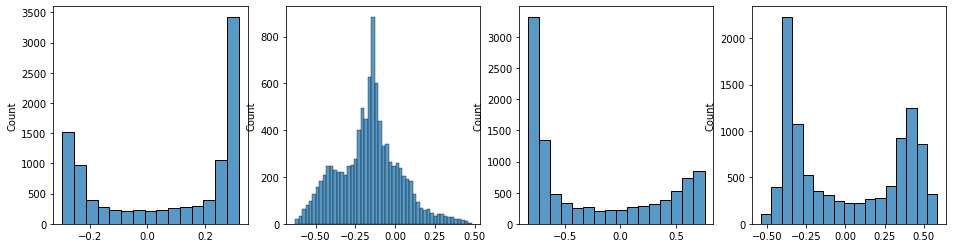

In [3]:
show_distribution(data, 1, 4)

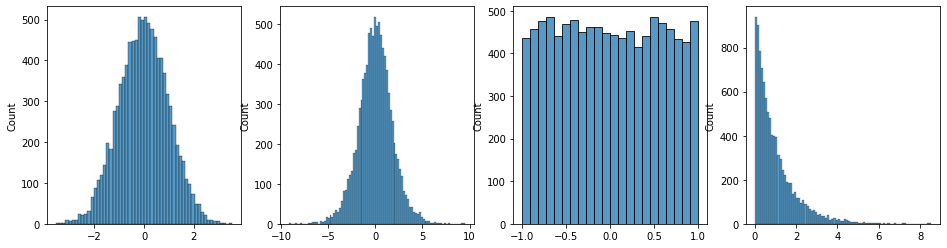

In [4]:
show_distribution(origin, 1, 4)

In [5]:
train = DataLoader(data, batch_size=64, shuffle=True, num_workers=2)

### MMD
Can consider use multiple kernels in the MMD-GAN

In [6]:
def rbf_kernel(X, Y, gamma=None):
    """
    Calculate the RBF kernel of the given data X and Y
    
    Args
    ----
    X, Y: torch.Tensor
        The target data
    gamma: float
        Inverse of the bandwidth (1/sigma)
        
    Returns
    -------
    """
    assert X.shape[1] == Y.shape[1], "The data should have the same dimension."

    # Calculate the Euclidean distance between the every pair of data in X and Y
    K = ((X[: ,np.newaxis, :] - Y[np.newaxis, :, :])**2).sum(axis=2)
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    
    K *= -gamma 
    return torch.exp(K)

def mmd2(X, Y, kernel=rbf_kernel):
    K_xx, K_xy, K_yy = kernel(X, X), kernel(X, Y), kernel(Y, Y)
    n = X.shape[0]
    numerator = n * (n - 1)
    return K_xx.sum() / numerator - (2*K_xy.sum())  /numerator + K_yy.sum() / numerator

In [7]:
mmd2(data, origin)

tensor(0.3630)

### Network

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.ReLU(),
            nn.Linear(input_size*2, input_size*3),
            nn.ReLU(),
            nn.Linear(input_size*3, input_size*2),
            nn.ReLU(),
            nn.Linear(input_size*2, input_size)
        )
    
    def __getitem__(self, idx):
        return self.net[idx]
    
    def forward(self, X):
        return self.net(X)

def weight_init(m: nn.Module):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)

In [9]:
net = Encoder(input_size=data.shape[1]).to(device)
net.apply(weight_init)
print(net)

Encoder(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
  )
)


### Optimizer

In [10]:
lr = 1e-3
betas = (0.9, 0.999)
wd = 0
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=betas, weight_decay=wd)

### Train

In [11]:
num_epochs = 100
loss_list = []

In [12]:
for epoch in range(num_epochs):
    for X in train:
        X = X.to(device=device)
        loss = mmd2(net(X), generate_y(batch_size=X.shape[0]).to(device=device))
        loss.backward()
        optimizer.step()
      
        loss_list.append(loss.item())
    print(f'[{epoch+1}/{num_epochs}] Loss: {loss_list[-1]}')

[1/100] Loss: 0.41269150376319885
[2/100] Loss: 0.31099021434783936
[3/100] Loss: 0.6556327939033508
[4/100] Loss: 0.23058581352233887
[5/100] Loss: 0.19607150554656982
[6/100] Loss: 0.22519707679748535
[7/100] Loss: 0.18265849351882935
[8/100] Loss: 0.2066301554441452
[9/100] Loss: 0.32120925188064575
[10/100] Loss: 0.18288654088974
[11/100] Loss: 0.1961054503917694
[12/100] Loss: 0.2111579179763794
[13/100] Loss: 0.17659400403499603
[14/100] Loss: 0.14001646637916565
[15/100] Loss: 0.16025707125663757
[16/100] Loss: 0.1385050117969513
[17/100] Loss: 0.13441964983940125
[18/100] Loss: 0.11912110447883606
[19/100] Loss: 0.15951576828956604
[20/100] Loss: 0.13233861327171326
[21/100] Loss: 0.23387648165225983
[22/100] Loss: 0.2592799663543701
[23/100] Loss: 0.1694316267967224
[24/100] Loss: 0.2147587090730667
[25/100] Loss: 0.16639721393585205
[26/100] Loss: 0.18052169680595398
[27/100] Loss: 0.19145435094833374
[28/100] Loss: 0.17947804927825928
[29/100] Loss: 0.2910774350166321
[30/10

<AxesSubplot:>

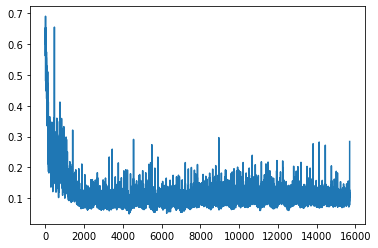

In [16]:
sns.lineplot(data=loss_list)

In [17]:
with torch.no_grad():
    y = net(data.to(device=device))
y

tensor([[ 2.5835e+05,  4.9572e+05, -2.7093e+05, -2.6945e+05],
        [-2.9400e-01, -3.5413e-01, -2.5264e-01,  1.0138e+00],
        [-2.9400e-01, -3.5413e-01, -2.5264e-01,  1.0138e+00],
        ...,
        [ 1.5404e+05,  2.9557e+05, -1.6155e+05, -1.6066e+05],
        [-2.9400e-01, -3.5413e-01, -2.5264e-01,  1.0138e+00],
        [-2.9400e-01, -3.5413e-01, -2.5264e-01,  1.0138e+00]], device='cuda:0')

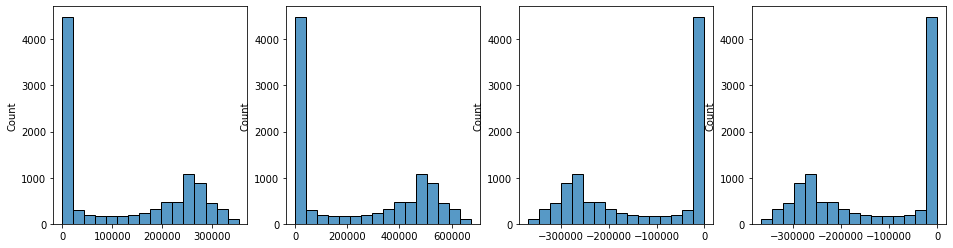

In [18]:
show_distribution(y.cpu(), 1, 4)